## Exploratory Data Analysis (EDA) of BTC/ETH price and GoogleNews search frequency of the word "cryptocurrency"

Due to volatility of crytocurrency market, one might wonder what is the best way to predict the currencies prices. As I came up with the project idea, the preliminary questions I had in mind were:

1. Is there any obvious correlation/lead-lag relationship between different crytocurrency market prices?
2. If the correlation existed, can we use the correlation information to predict future price?
3. Does the rise/fall in search frequency of the word "crytocurrency" on GoogleNews imply trading signal?

The following code queries and visualize data in order to explore the preliminary questions. The stretch goal is to gain insights beyond preliminary questions that will lead to better data analysis in the future



In [2]:
# Getting price data of BTC and ETH using Cryptocompare API

import requests
import json
import pandas as pd
from pandas.io.json import json_normalize
import datetime

# Indicate how many rows of data here
lim = '9000' 
story_coin = ['BTC', 'ETH']
story_data = pd.DataFrame()
for i in story_coin:
    URL = 'https://min-api.cryptocompare.com/data/histohour?fsym='+i+'&tsym=USD&limit='+lim
    data = requests.get(URL)
    json_data = data.json()
    table = json_normalize(json_data, 'Data').set_index('time')
    table.index = pd.to_datetime(table.index ,unit='s')
    story_data = pd.concat([story_data, table.high], axis=1)
story_data.columns = story_coin

In [3]:
# Getting data from Google Trends using Pytrends API

from pytrends.request import TrendReq
# Login to Google. Only need to run this once
pytrend = TrendReq()
# Create payload and capture API tokens. Only needed for interest_over_time(), interest_by_region() & related_queries()
pytrend.build_payload(kw_list=['cryptocurrency'], cat=16, timeframe='2017-02-12 2017-10-12')

story_ggtrends = pytrend.interest_over_time()
# Upsampling daily data to hourly data
story_ggtrends = story_ggtrends.resample('1h').pad().drop(['isPartial'], axis='columns')
story_ggtrends.columns = ['SearchFrequency']


In [4]:
# Joining two data frames
story_combined = pd.concat([story_data, story_ggtrends], axis=1).dropna(how='any')
story_combined_scaled = story_combined.copy(deep=True)


In [5]:
# Feature Scaling. This will capture trend information and makes visualization more meaningful. 
from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
story_combined_scaled['BTC'] = sc_x.fit_transform(story_combined_scaled['BTC'].values.reshape(-1,1))
story_combined_scaled['ETH'] = sc_x.fit_transform(story_combined_scaled['ETH'].values.reshape(-1,1))
story_combined_scaled['SearchFrequency'] = sc_x.fit_transform(story_combined_scaled['SearchFrequency'].values.reshape(-1,1))


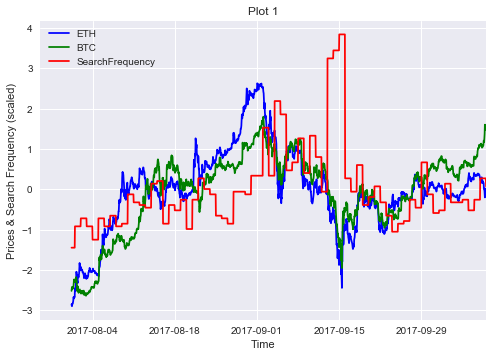

In [6]:
# Plot 1- overlay plot of ETC/BTC prices and GoogleNews search frequency data. 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
plt.plot(story_combined_scaled.index, story_combined_scaled['ETH'], color='blue')
plt.plot(story_combined_scaled.index, story_combined_scaled['BTC'], color='green')
plt.plot(story_combined_scaled.index, story_combined_scaled['SearchFrequency'], color='red')
plt.xlim(('2017-07-26', '2017-10-10'))
plt.legend(loc='upper left')
plt.xlabel('Time')
plt.ylabel('Prices & Search Frequency (scaled)')
plt.title('Plot 1')
plt.show()

From **Plot 1**, I've obsereved the following:
1. Sharp rises in search frequency are coupled with price drops
2. BTC and ETH prices tend to converge when there's a sharp rise in search frequency

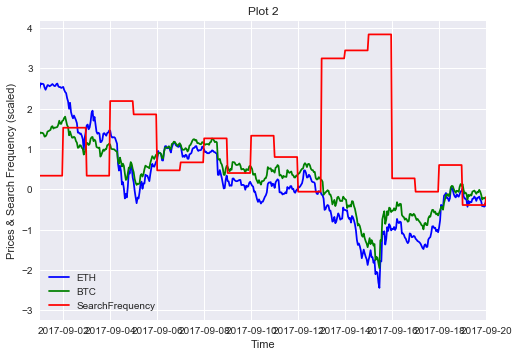

In [8]:
# Plot 2- overlay plot of ETC/BTC prices and GoogleNews search frequency data in 20 days timespand (during drop)

plt.plot(story_combined_scaled.index, story_combined_scaled['ETH'], color='blue')
plt.plot(story_combined_scaled.index, story_combined_scaled['BTC'], color='green')
plt.plot(story_combined_scaled.index, story_combined_scaled['SearchFrequency'], color='red')
plt.xlim(('2017-09-01', '2017-09-20'))
plt.legend(loc='lower left')
plt.xlabel('Time')
plt.ylabel('Prices & Search Frequency (scaled)')
plt.title('Plot 2')
plt.show()

According to **Plot 2**, it looks like sharp rise in search frequency leads ETH/BTC price drop. However, this conclusion is based on just 2 events

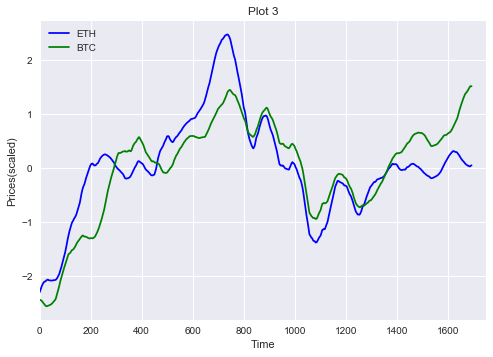

In [10]:
# Plot 3- BTC/ETH moving averages
import numpy as np
a = 50
b = a-1
def moving_average(a, n):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

ma_combined = pd.DataFrame()
ma_combined['ETH'] = moving_average(story_combined_scaled['ETH'].values, a)
ma_combined['BTC'] = moving_average(story_combined_scaled['BTC'].values, a)


plt.plot(ma_combined.index, ma_combined['ETH'], color='blue')
plt.plot(ma_combined.index, ma_combined['BTC'], color='green')
#plt.axvline(1218, color='red')
plt.xlim((0, 1750))
plt.legend(loc='upper left')
plt.ylabel('Prices(scaled)')
plt.xlabel('Time')
plt.title('Plot 3')
plt.show()

Based on **Plot 3**, there seem to be correlation between ETH and BTC prices and that ETH leads BTC. However, a statistical test is needed to confirm the relationship

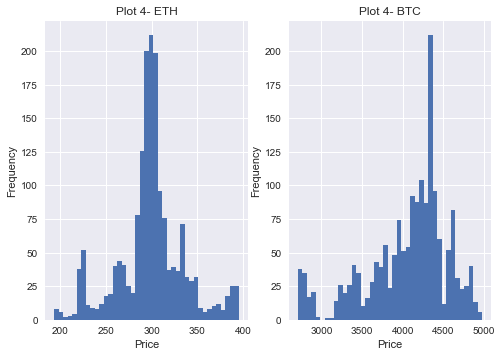

In [12]:
# Plot 4- BTC/ETH histogram
n_data = len(story_combined['ETH'])
n_bins = int(np.sqrt(n_data))
plt.subplot(1, 2, 1)
story_combined['ETH'].hist(bins=n_bins)
plt.ylabel('Frequency')
plt.xlabel('Price')
#plt.xlim((-2, 2))
plt.title('Plot 4- ETH', loc='center')
plt.subplot(1, 2, 2)
story_combined['BTC'].hist(bins=n_bins)
plt.ylabel('Frequency')
plt.xlabel('Price')
#plt.xlim((-2, 2))
plt.title('Plot 4- BTC', loc='center')
plt.show()

In [13]:
#not sure if this says anything beside distribution isn't normal. does this say BTC is less stable? 

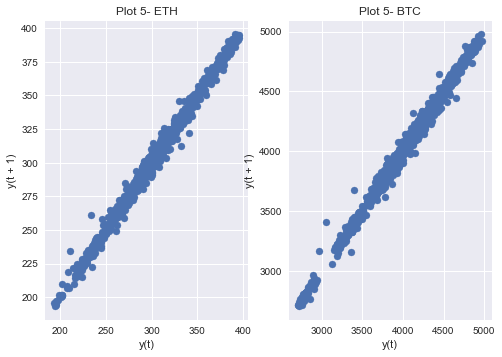

In [14]:
# Plot 5- BTC/ETH lag1 scatter plot
from pandas.plotting import lag_plot
plt.subplot(1, 2, 1)
lag_plot(story_combined['ETH'])
plt.title('Plot 5- ETH', loc='center')
plt.subplot(1, 2, 2)
lag_plot(story_combined['BTC'])
plt.title('Plot 5- BTC', loc='center')
plt.show()

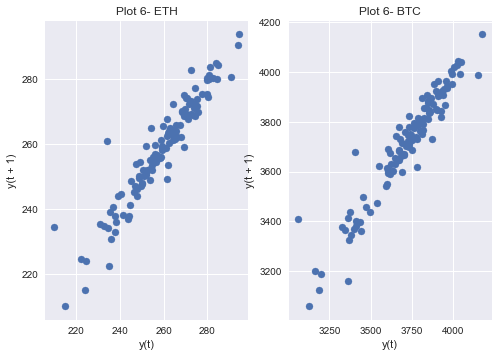

In [15]:
# Plot 6- BTC/ETH lag1 scatter plot during sharp drop (2017-09-13':'2017-09-17)
plt.subplot(1, 2, 1)
lag_plot(story_combined.loc['2017-09-13':'2017-09-17']['ETH'])
plt.title('Plot 6- ETH', loc='center')
plt.subplot(1, 2, 2)
lag_plot(story_combined.loc['2017-09-13':'2017-09-17']['BTC'])
plt.title('Plot 6- BTC', loc='center')
plt.show()

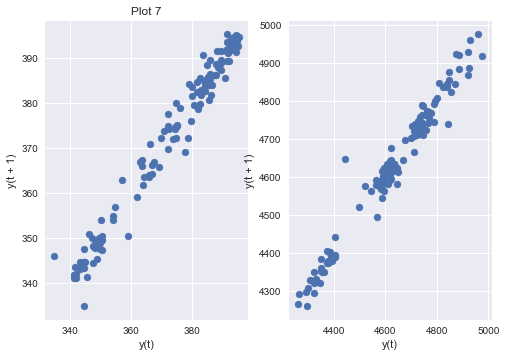

In [16]:
# Plot 7- BTC/ETH lag1 scatter plot during peak (2017-08-28':'2017-09-02)
plt.subplot(1, 2, 1)
lag_plot(story_combined.loc['2017-08-28':'2017-09-02']['ETH'])
plt.title('Plot 7', loc='center')
plt.subplot(1, 2, 2)
lag_plot(story_combined.loc['2017-08-28':'2017-09-02']['BTC'])
plt.show()

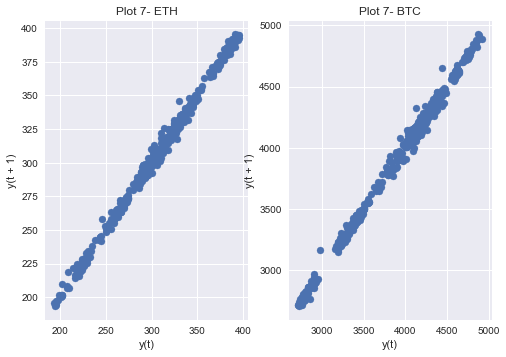

In [17]:
# Plot 7- BTC/ETH lag1 scatter plot while trending up (2017-07-28':'2017-09-01)
plt.subplot(1, 2, 1)
lag_plot(story_combined.loc[:'2017-09-01']['ETH'])
plt.title('Plot 7- ETH', loc='center')
plt.subplot(1, 2, 2)
lag_plot(story_combined.loc[:'2017-09-01']['BTC'])
plt.title('Plot 7- BTC', loc='center')
plt.show()

Based on **Plot 5-7**, as expected, there seem to be worse correlation between y(t) and y(t+1) when price dropped/peak. The correlation is best while the pricing is trending up with no sharp drops. <br><br>
This finding led me to believe that Autocorrelation prediction might not be the best idea when it comes to cryptocurrency markets. The autocorrelation function (ACF) measures the linear predictability of the series at time t, say x_t, using only the value x_s, where s and t denote two valuation points in time. Because it's a linear model and that it uses solely the historical data, I'm convinced that other Machine Learning models will outperform Autocorrelation prediction. 


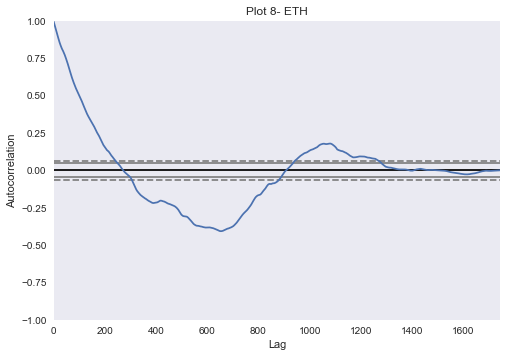

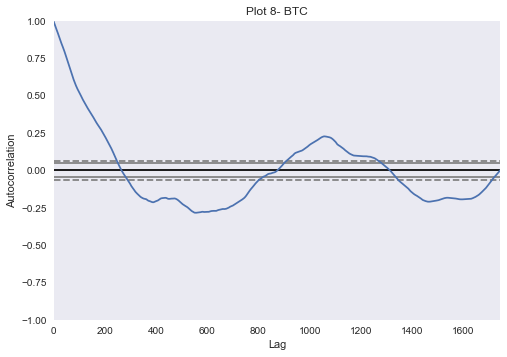

In [23]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(story_combined['ETH'])
plt.title('Plot 8- ETH', loc='center')
plt.show()
autocorrelation_plot(story_combined['BTC'])
plt.title('Plot 8- BTC', loc='center')
plt.show()

In [ ]:
# what does this say about BTC and ETH?
# what does this say bout the claim "autocorrelation isn't a good idea"?

### Conclusion:
-  There seem to be high correlation between the rise in search frequency and the drop in currencies prices 
-  The correlation between an observation and the previous observation (lag1) improves when theres no sharp drop 
-  There seem to be correlation between BTC/ETH prices and that ETH leads BTC. A statistics test is needed to confirm the finding.
<br><br>
From the conclusion above, my hypothesis is that Autocorrelation model doesn't perform well in volatile markets. With careful use of features (i.e.GoogleNews search frequency), other Machine Learning models would better predict market volatility.

Next steps are:
1. Come up with more meaningful features
2. Confirm correlations between currencies using Granger Causality
3. Analyze price history using Autocorrelation 
4. Based on 1,2,3, come up with a Machine Learning model that best predict future prices